<a href="https://colab.research.google.com/github/snu-digital-finance/ProductionML/blob/main/checkpoint_review_AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualization

In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import count
import numpy as np
import re

FIG_NO = count(1)

def _expand_title(title_prefix: str) -> str:
    """
    Parse tokens like "<TL y1 + y2 → y2>" or "[TL y1 + y2 → y2]" and
    convert to a readable figure title, e.g., "y1 transfer learned with y2"
    (if target == finetune) or "y1 transfer learned with y2 to predict y3".
    Falls back to the raw prefix (with brackets removed) if parsing fails.
    """
    # extract inside <> or []
    m = re.search(r'[\[<]\s*(.*?)\s*[\]>]', title_prefix or "")
    core = (m.group(1) if m else title_prefix or "").strip()

    # try to parse "TL A + B → T"
    m2 = re.match(r'^TL\s+(.+?)\s*\+\s*(.+?)\s*→\s*(.+)$', core)
    if m2:
        A, B, T = [s.strip() for s in m2.groups()]
        if T == B:
            return f"{A} transfer learned with {B}"
        else:
            return f"{A} transfer learned with {B} to predict {T}"

    # otherwise just remove brackets and return
    return core

def draw_triptych(title_prefix, Kv, Lv, y_true, y_pred,
                  fig_no=None, caption=None, y_lim=None, show=True):
    if fig_no is None:
        fig_no = next(FIG_NO)

    mse = (y_true - y_pred) ** 2

    cmap_y = "Greys"
    m_true, m_pred = "o", "^"
    edge = "black"

    fig = plt.figure(figsize=(16, 5))
    gs = GridSpec(nrows=1, ncols=3, figure=fig, width_ratios=[1, 1, 1])

    # (a) True — 3D
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')
    ax1.scatter(Kv, Lv, y_true, c=y_true, cmap=cmap_y,
                alpha=0.8, s=14, marker=m_true, edgecolor=edge, linewidth=0.3)
    ax1.set_title("(a) True Y")
    ax1.set_xlabel("K"); ax1.set_ylabel("L"); ax1.set_zlabel("Y")
    ax1.set_xlim(0, 1); ax1.set_ylim(0, 1)
    if y_lim is not None:
        ax1.set_zlim(*y_lim)

    # (b) Predicted — 3D
    ax2 = fig.add_subplot(gs[0, 1], projection='3d')
    ax2.scatter(Kv, Lv, y_pred, c=y_pred, cmap=cmap_y,
                alpha=0.8, s=14, marker=m_pred, edgecolor=edge, linewidth=0.3)
    ax2.set_title("(b) Predicted Ŷ")
    ax2.set_xlabel("K"); ax2.set_ylabel("L"); ax2.set_zlabel("Ŷ")
    ax2.set_xlim(0, 1); ax2.set_ylim(0, 1)
    if y_lim is not None:
        ax2.set_zlim(*y_lim)

    # (c) MSE — 2D: x = varying axis (K or L), y = MSE
    ax3 = fig.add_subplot(gs[0, 2])
    if np.nanstd(Lv) < 1e-9:
        x_vals, x_label = np.ravel(Kv), "K"
    elif np.nanstd(Kv) < 1e-9:
        x_vals, x_label = np.ravel(Lv), "L"
    else:
        x_vals, x_label = np.ravel(Kv), "K"
    ax3.scatter(x_vals, np.ravel(mse), c="dimgray", s=14,
                marker="s", edgecolor=edge, linewidth=0.3)
    ax3.set_title("(c) MSE (Y−Ŷ)^2")
    ax3.set_xlabel(x_label); ax3.set_ylabel("MSE")
    ax3.set_xlim(0, 1); ax3.set_ylim(0, 1)

    # Figure title from expanded prefix
    pretty = _expand_title(title_prefix)
    cap = f"Figure {fig_no}. {pretty}"
    if caption:
        cap += f" — {caption}"
    fig.suptitle(cap, fontsize=18, y=0.98)

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, bottom=0.05, wspace=0.35)
    ax1.text2D(0.02, 0.92, "○ True,  △ Pred,  ■ MSE",
               transform=ax1.transAxes, fontsize=9)

    if show:
      plt.show()


## Data Generation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# === 1. Data ===
np.random.seed(42)
tf.random.set_seed(42)

n = 1000
noise_scale = 0.05

# K-intensive: K~U(0,1), L=0
K = np.random.rand(n, 1)
L0 = np.zeros((n, 1))
X_K = np.hstack([K, L0])

# L-intensive: K=0, L~U(0,1)
K0 = np.zeros((n, 1))
L = np.random.rand(n, 1)
X_L = np.hstack([K0, L])

# Targets with noise
y1 = K**3 + np.random.normal(0, noise_scale, size=(n, 1))      # K³ + noise
y2 = -K**3 + np.random.normal(0, noise_scale, size=(n, 1))     # −K³ + noise
y3 = L**3 + np.random.normal(0, noise_scale, size=(n, 1))      # L³ + noise
y4 = -L**3 + np.random.normal(0, noise_scale, size=(n, 1))


## Build & Train Model

### Build Original Model

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Lambda

# Original Model - 5 layer trained on y1
def build_model():
    model = Sequential([
        tf.keras.Input(shape=(2,)),
        Lambda(tf.nn.relu, name="input_relu"),
        Dense(8, activation="relu"),
        Dense(8, activation="relu"),
        Dense(8, activation="relu"),
        Dense(1, activation="linear")
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

model = build_model()
model.fit(X_K, y1, epochs=100, batch_size=32, verbose=0)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_relu (Lambda)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533 (2.09 KB)

 Trainable params: 177 (708.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 356 (1.39 KB)

# Run

## Original Model Evaluated on untrained data - high MSE

[Base y1 → y2] MSE = 0.566978
[Base y1 → y3] MSE = 0.147025


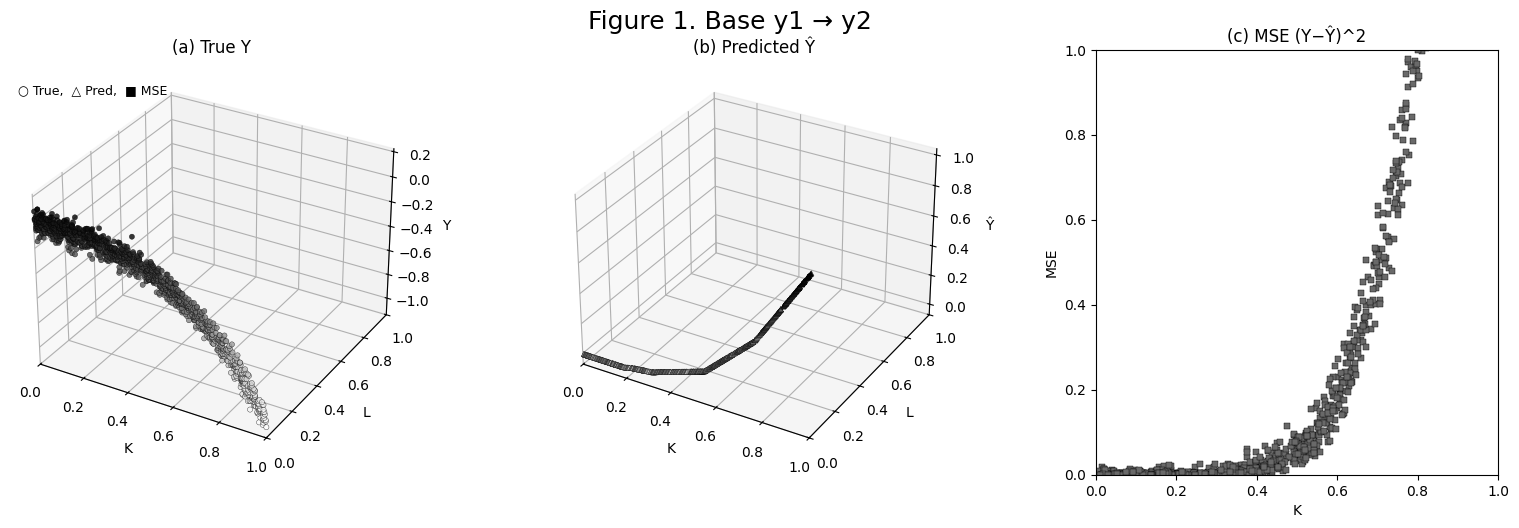

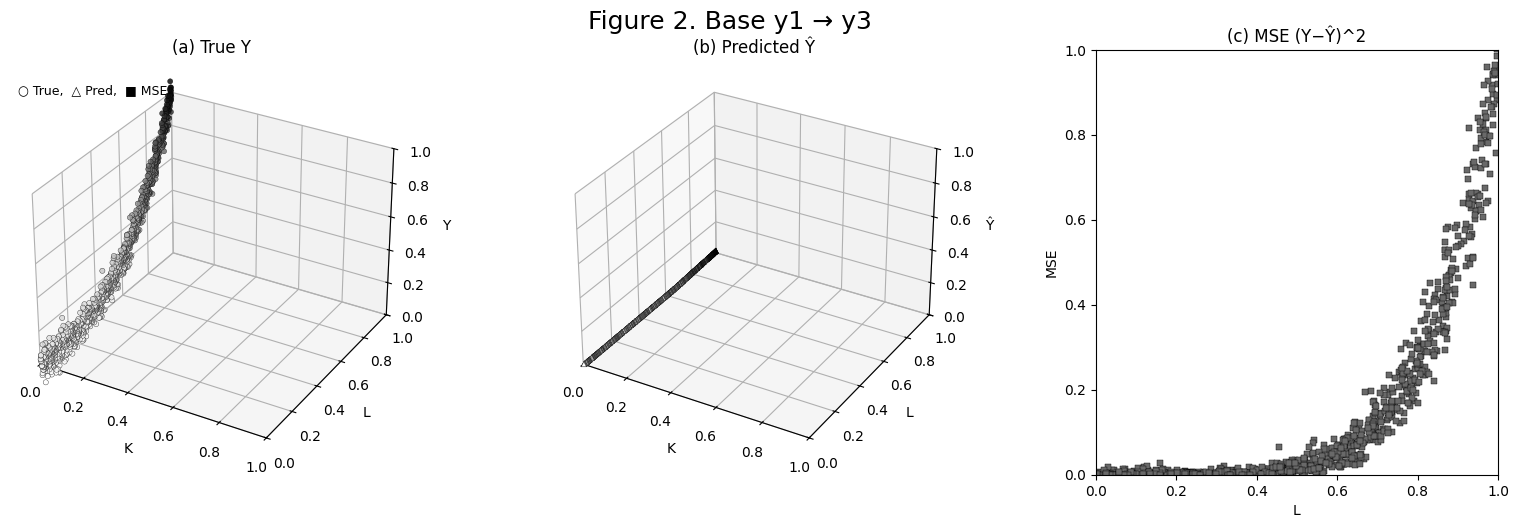

In [4]:
# Baseline (no transfer): use original `model` trained on y1
from sklearn.metrics import mean_squared_error

# Predict y2 (K^2) and y3 (L^3) with the base model
y2_pred_base = model.predict(X_K, verbose=0)
y3_pred_base = model.predict(X_L, verbose=0)

# Compute MSEs for reference
mse_y2_base = mean_squared_error(y2, y2_pred_base)
mse_y3_base = mean_squared_error(y3, y3_pred_base)
print(f"[Base y1 → y2] MSE = {mse_y2_base:.6f}")
print(f"[Base y1 → y3] MSE = {mse_y3_base:.6f}")

# Visualize: (a) True Y, (b) Pred Ŷ, (c) 2D MSE plot (x = varying axis, y = MSE)
# y2 task: vary K (L=0)
draw_triptych("[Base y1 → y2]", K, L0, y2, y2_pred_base)

# y3 task: vary L (K=0)
draw_triptych("[Base y1 → y3]", K0, L, y3, y3_pred_base, y_lim=(0, 1))


## Show 10 Trials and Mean (model trained on K-intensive predicting L-intensive data)

In [5]:
# ---------- Train 10 independent models on y1, evaluate on L (y3) ----------
from sklearn.metrics import mean_squared_error
import numpy as np

n_trials = 10
L_preds = []
mses = []

# 1) Train 10 models (random init), each on y1, then predict y3
for t in range(n_trials):
    print(f"[Trial {t+1}/{n_trials}] training on y1 ...")
    m = build_model()
    m.fit(X_K, y1, epochs=50, batch_size=32, verbose=0)   # train ONLY on y1
    L_pred_t = m.predict(X_L, verbose=0).ravel()           # evaluate on L (y3 task)
    L_preds.append(L_pred_t)

    mse_t = mean_squared_error(y3.ravel(), L_pred_t)
    mses.append(mse_t)
    print(f"[Trial {t+1}/{n_trials}] MSE (y1 → y3) = {mse_t:.6f}")

# 2) Prepare 1D views for plotting
L_preds_raw = L_preds.copy()
L_preds = np.vstack(L_preds)              # shape (10, N)
L_true_1d = y3.ravel()
K0_1d = K0.ravel()
L_1d  = L.ravel()




[Trial 1/10] training on y1 ...
[Trial 1/10] MSE (y1 → y3) = 0.183400
[Trial 2/10] training on y1 ...
[Trial 2/10] MSE (y1 → y3) = 0.070662
[Trial 3/10] training on y1 ...
[Trial 3/10] MSE (y1 → y3) = 0.126581
[Trial 4/10] training on y1 ...
[Trial 4/10] MSE (y1 → y3) = 0.022733
[Trial 5/10] training on y1 ...
[Trial 5/10] MSE (y1 → y3) = 0.066535
[Trial 6/10] training on y1 ...
[Trial 6/10] MSE (y1 → y3) = 0.020245
[Trial 7/10] training on y1 ...
[Trial 7/10] MSE (y1 → y3) = 0.132197
[Trial 8/10] training on y1 ...
[Trial 8/10] MSE (y1 → y3) = 0.155120
[Trial 9/10] training on y1 ...
[Trial 9/10] MSE (y1 → y3) = 0.468408
[Trial 10/10] training on y1 ...
[Trial 10/10] MSE (y1 → y3) = 0.082129


In [6]:
# 4) Plot mean prediction across 10 trials
L_pred_mean = L_preds.mean(axis=0)
mse_mean = mean_squared_error(L_true_1d, L_pred_mean)
print(f"\nMean MSE over {n_trials} trials (y1 → y3): {mse_mean:.6f}")


Mean MSE over 10 trials (y1 → y3): 0.102908


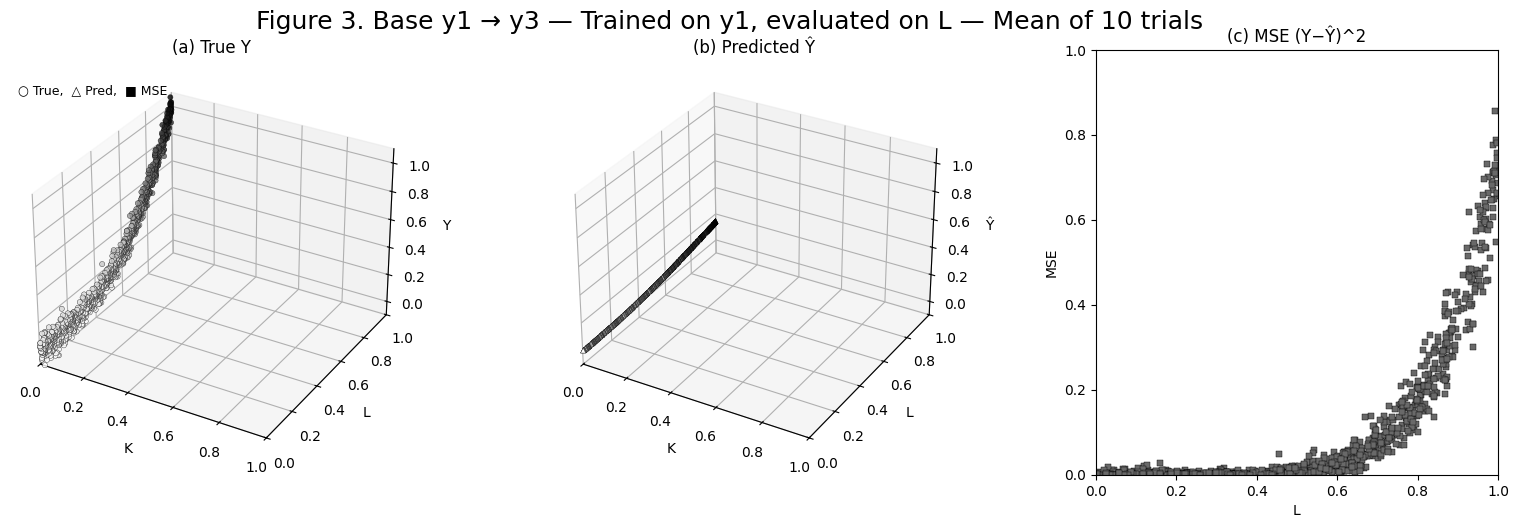

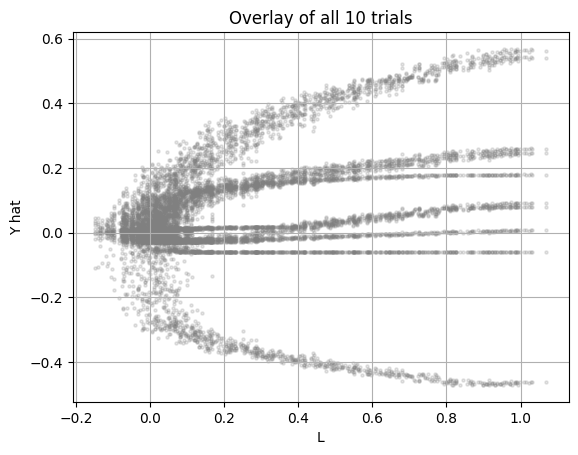

In [7]:
# mean + all trials

draw_triptych(
    title_prefix="[Base y1 → y3]",
    Kv=K0_1d, Lv=L_1d,
    y_true=L_true_1d, y_pred=L_pred_mean,
    fig_no=2+1,
    caption=f"Trained on y1, evaluated on L — Mean of {n_trials} trials",
    y_lim=(-0.1, 1.1)
)
# after drawing mean, overlay each trial

for t in range(n_trials):
    plt.scatter(L_true_1d, L_preds_raw[t], color="gray", alpha=0.2, s=5)
plt.title("Overlay of all 10 trials")
plt.xlabel("L")
plt.ylabel("Y hat")
plt.grid()
plt.show()


## Transfer Learning with 1 layer open

In [8]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

def tf_1layer_y2_y3(ep):
    # --- TL: last-layer-only (y2) ---
    model_tf_1layer_y2 = Sequential(name="model_tf_1layer_y2")

    # add pretrained backbone layers EXCEPT the original final output layer
    for lyr in model.layers[:-1]:   # exclude model.layers[-1]
        lyr.trainable = False       # freeze backbone
        model_tf_1layer_y2.add(lyr)

    # add a NEW trainable output head (only this layer is trainable)
    model_tf_1layer_y2.add(Dense(1, activation="linear", name="head_1layer_y2"))

    model_tf_1layer_y2.compile(optimizer="adam", loss="mse")
    model_tf_1layer_y2.fit(X_K, y2, epochs=ep, batch_size=32, verbose=0)


    # --- TL: last-layer-only (y3) ---
    model_tf_1layer_y3 = Sequential(name="model_tf_1layer_y3")

    for lyr in model.layers[:-1]:
        lyr.trainable = False
        model_tf_1layer_y3.add(lyr)

    model_tf_1layer_y3.add(Dense(1, activation="linear", name="head_1layer_y3"))

    model_tf_1layer_y3.compile(optimizer="adam", loss="mse")
    model_tf_1layer_y3.fit(X_L, y3, epochs=ep, batch_size=32, verbose=0)

    # (optional) quick check
    print("\n[Trainable flags: model_tf_1layer_y2]")
    for lyr in model_tf_1layer_y2.layers:
        print(f"{lyr.name:28s} trainable={lyr.trainable}")

    return model_tf_1layer_y2, model_tf_1layer_y3



[Trainable flags: model_tf_1layer_y2]
input_relu                   trainable=False
dense                        trainable=False
dense_1                      trainable=False
dense_2                      trainable=False
head_1layer_y2               trainable=True


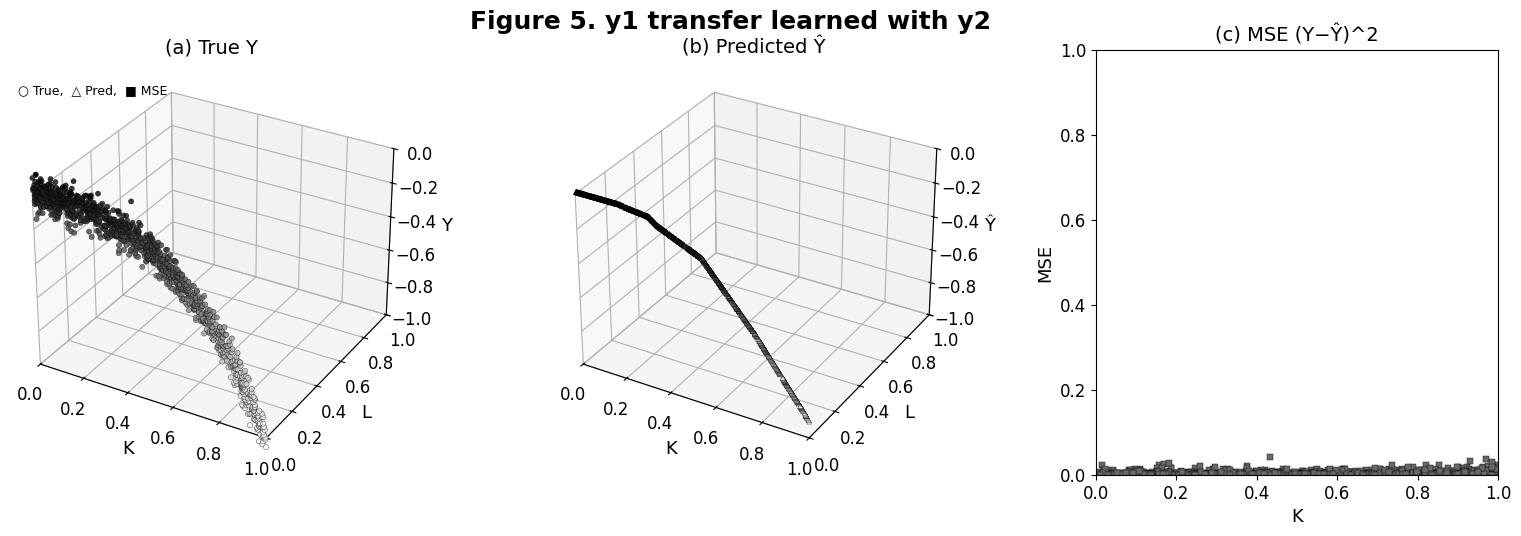

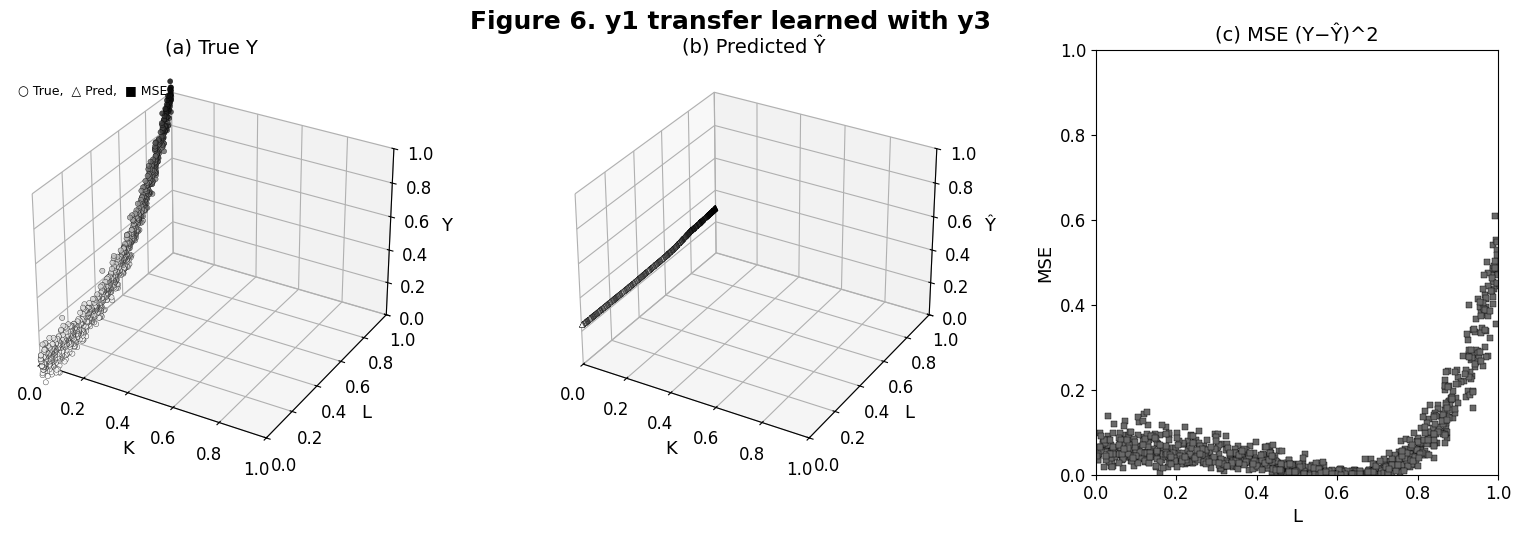

In [22]:
model_tf_1layer_y2, model_tf_1layer_y3 = tf_1layer_y2_y3(25)

y2_pred_tf = model_tf_1layer_y2.predict(X_K, verbose=0)
y3_pred_tf = model_tf_1layer_y3.predict(X_L, verbose=0)

draw_triptych("[TL y1 + y2 → y2]", K, L0,  y2, y2_pred_tf, y_lim = (-1,0))
draw_triptych("[TL y1 + y3 → y3]", K0, L, y3, y3_pred_tf, y_lim = (0,1))


# Feature Norm

### library

In [34]:
import matplotlib.style as style

# Set random seed for reproducibility
np.random.seed(42); tf.random.set_seed(42)
rng = np.random.default_rng(42)
style.use('tableau-colorblind10')
plt.rcParams.update({
    'font.size': 14, 'figure.titlesize': 18, 'figure.titleweight': 'bold',
    'figure.subplot.hspace': 0.3, 'figure.subplot.wspace': 0.3, 'axes.titlesize': 14, 'axes.labelsize': 13, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 12,
})


# --------------------------
# 1) Robust mask computation
# --------------------------
def get_relu_keep_probs_aligned(model, X_batch):
    """
    Compute per-weight-layer ReLU pass probabilities p = P(z>0).
    Returns:
      masks: list of numpy arrays (or None) for each weight-containing layer (in order encountered)
      layer_indices: list of model.layers indices that correspond to each mask (alignment info)
    Notes:
      - X_batch: tf.Tensor shape (batch, input_dim), representative batch
      - Safe for models that include Activation/Lambda/Dropout/etc.
    """
    X = tf.identity(X_batch)
    masks, layer_indices = [], []

    for idx, layer in enumerate(model.layers):
        ws = layer.get_weights()
        if len(ws) == 0:
            try: # no weights -> forward propagate to update X for subsequent layers
                X = layer(X)
            except Exception:
                # fallback: if layer defines 'activation' wrapper, apply it; else skip
                act = getattr(layer, "activation", None)
                if act is not None:
                    X = act(X)
            continue

        # layer has weights (e.g., Dense). compute pre-activation z = X @ W + b (if present)
        W = ws[0]
        W_tf = tf.convert_to_tensor(W, dtype=tf.float32)
        z = tf.matmul(X, W_tf)
        if len(ws) > 1:
            b_tf = tf.convert_to_tensor(ws[1], dtype=tf.float32)
            z = z + b_tf  # broadcast

        act = getattr(layer, "activation", None)
        masks.append(
            tf.reduce_mean(tf.cast(z > 0.0, tf.float32), axis=0).numpy()
            if (act == tf.keras.activations.relu) else None)
        layer_indices.append(idx)

        try: # propagate X using the actual layer (so next z computed correctly)
            X = layer(X)
        except Exception:
            X = act(z) if act is not None else z


    return masks, layer_indices

def compute_forward_path(
     Ws, Bs, i,
     dense_layer_indices, layer_idxs,
     masks, include_bias=False
):
    input_dim = Ws[0].shape[0]
    if not (0 <= i < input_dim):
        raise ValueError(f"feature index i out of range: i={i}, input_dim={input_dim}")

    # one-hot input e
    e = np.zeros(input_dim, dtype=np.float64)
    e[i] = 1.0

    path, v = [], None
    for k, W in enumerate(Ws):
        if v is None:
            # first weight-layer: contribution e @ W
            v = e @ W  # shape (out_dim,)
        else:
            # find mask position for prev_layer_idx inside dense_layer_indices
            mask_prev = None
            try:  # apply mask corresponding to previous weight-layer (if exists)
                pos = dense_layer_indices.index(layer_idxs[k-1])
                mask_prev = masks[pos]  # might be None
            except ValueError:
                mask_prev = None

            if mask_prev is not None:
                v = v * mask_prev  # elementwise
            v = v @ W # propagate to next layer

        if include_bias and Bs[k] is not None:
            v = v + Bs[k]
        path.append(v.copy())
        # print(path[-1].shape, sum(path[-1]**2)**(0.5))
    return path

def layer_stats(path):
  layer_L1 = [np.sum(np.abs(x)) for x in path]
  total = sum(layer_L1) if sum(layer_L1) != 0 else 1.0
  layer_pct = [x / total for x in layer_L1]
  layer_units = [x.shape[0] for x in path]
  return layer_L1, layer_pct, layer_units


# --------------------------
# 2) Feature path computation
# --------------------------
def feature_path(model, i, X_batch, include_bias=False):
    """
    Returns list [v^(1), v^(2), ...] for feature i (one-hot input).
    - X_batch: representative batch (tf.Tensor) for mask estimation
    - include_bias: if True, add layer bias to v^(k) (usually False for 'feature contribution' view)
    The returned path aligns with weight-containing layers only.
    Also returns metadata in dict form.
    """
    masks, dense_layer_indices = get_relu_keep_probs_aligned(model, X_batch)

    # gather weights (+bias optionally) for weight-containing layers, in same encountered order
    Ws, Bs, layer_idxs = [], [], []
    for idx, layer in enumerate(model.layers):
        ws = layer.get_weights()
        if len(ws) == 0:
            continue
        Ws.append(ws[0].astype(np.float64))
        Bs.append((ws[1].astype(np.float64) if (include_bias and len(ws) > 1) else None))
        layer_idxs.append(idx)

    if len(Ws) == 0:
        raise ValueError("Model has no weight-containing layers.")

    path = compute_forward_path(
        Ws, Bs, i, dense_layer_indices,
        layer_idxs, masks, include_bias
    )

    layer_L1, layer_pct, layer_units = layer_stats(path)

    return {
        "path": path,
        "layer_L1": layer_L1,
        "layer_pct": layer_pct,
        "layer_units": layer_units,
        "layer_idxs": layer_idxs,
        "masks": masks,
        "dense_layer_indices": dense_layer_indices
    }


In [35]:
# --------------------------
# 3) Plot helper (no external fm/sp)
# --------------------------
def plot_feature_path(model, num_features, X_batch, vmin=None, vmax=None, cmap='gray', caption=''):
    """
    Plot heatmaps per feature (rows) x weight-layer (cols) and a norm-evolution plot.
    - num_features: how many feature indices [0..num_features-1] to show (rows)
    - X_batch: representative batch for mask computation
    - vmin/vmax: optional fixed color scale; if None scale per whole figure
    """
    # compute all feature paths
    feat_vecs = [feature_path(model, i, X_batch)['path'] for i in range(num_features)]
    cols = len(feat_vecs[0])
    rows = num_features

    # compute global vmin/vmax if not provided
    all_vals = np.concatenate([v.flatten() for row in feat_vecs for v in row])
    if vmin is None:
        vmin = all_vals.min()
    if vmax is None:
        vmax = all_vals.max()
    # symmetric colorbar around 0 if values roughly symmetric
    absmax = max(abs(vmin), abs(vmax))
    vmin, vmax = -absmax, absmax

    fig, axes = plt.subplots(rows, cols, figsize=(2.8*cols+1, 1.2*rows), squeeze=True)
    #fig.suptitle("Feature influence (rows=features, cols=weight-layers)\n\n", fontsize=14)

    layer_titles = [f"Output vector of {k+2} layer\n(out={feat_vecs[0][k].shape[0]})" for k in range(cols)]

    for i, vecs in enumerate(feat_vecs):
        for k, v in enumerate(vecs):
            ax = axes[i][k]
            ax.imshow(v[np.newaxis, :], aspect='auto', vmin=vmin, vmax=vmax, cmap=cmap)
            if i == 0:
                ax.set_title(layer_titles[k], fontsize=10)
            if k == 0:
                ax.set_ylabel(f"{['K','L'][i]} var", fontsize=10)
            ax.set_yticks([])
            ax.set_xticks([])

    cbar = fig.colorbar(
        plt.cm.ScalarMappable(cmap=cmap), ax=axes.ravel().tolist(),
        orientation='vertical', fraction=0.12, pad=0.02)
    cbar.set_label("Value")
    plt.show()

    # norm-evolution plot
    plt.figure(figsize=(6,3))
    marker = ["x", "o"]
    for i, vecs in enumerate(feat_vecs):
        norms = [np.linalg.norm(v, 2) for v in vecs]
        plt.plot(range(2, cols+2), norms, marker=marker[i], label=f"{['K','L'][i]} var", color='gray', markersize=10)
    plt.xlabel("weight-layer index")
    plt.ylabel("||influence||_2")
    plt.title(f"Feature Influence Norm through Each Layer\n{caption}")
    plt.xticks(range(2, cols+2))
    plt.legend()
    plt.grid(alpha=0.2)
    plt.ylim(0, 2.0)
    plt.show()

In [44]:
def plot_feature_overlay(model, feat_idx, inputs, X_template, cmap_list=None, caption=''):
    """
    Overlay feature influence evolution across layers for multiple input values.
    - feat_idx: which feature index to analyze
    - inputs: list of scalar values for that feature, e.g. [0, 0.5, 1]
    - X_template: a batch used for computing masks (copy & modify one feature)
    """
    if cmap_list is None:
        cmap_list = ['gray', 'Reds', 'Blues', 'Greens', 'Purples']

    results = []

    for val in inputs:
        X_mod = X_template.copy()
        path = feature_path(model, feat_idx, X_mod)['path']
        results.append((val, path))

    cols = len(results[0][1])


    # Norm overlay
    plt.figure(figsize=(5,3))
    for idx, (val, path) in enumerate(results):
        norms = [np.linalg.norm(v,2) for v in path]
        marker = ["x", None, "."][(idx)//100]
        linestyle = [":", "-", ":"][(idx)//100]
        if idx%100!=0:
          plt.plot(range(2, cols+2), norms, marker=marker, linewidth=2, color='gray', linestyle=linestyle)
        else:
          label = ['lower input', 'origin', 'upper input'][(idx)//100]
          plt.plot(range(2, cols+2), norms, marker=marker, linewidth=2, label=label, color='gray', linestyle=linestyle)
    plt.xlabel("Layer index")
    plt.ylabel("|| influence ||_2")
    plt.title(f"Feature Influence Norm: Overlay\n")

    plt.legend(
        loc='upper left', bbox_to_anchor=(1.0, 1.0),
    ); plt.grid(alpha=0.25); plt.show()


### Forward Propagation

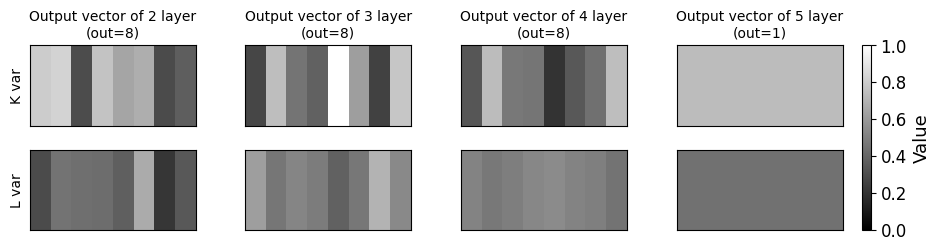

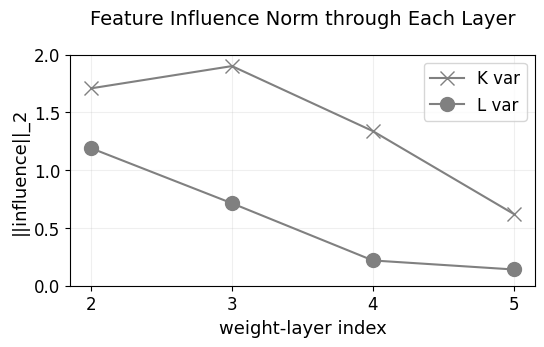

In [37]:
plot_feature_path(
    model, num_features=2, X_batch=X_K,
    caption="") # Original Model(K^3) does not react to L var

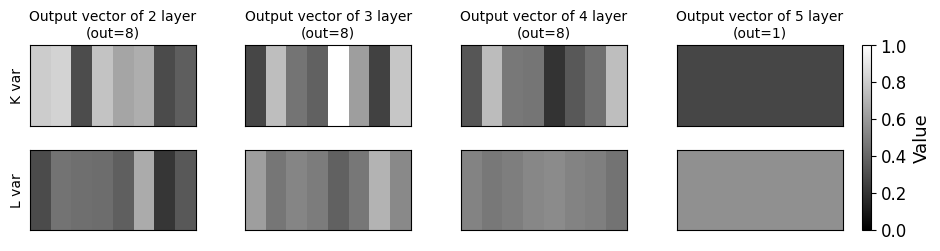

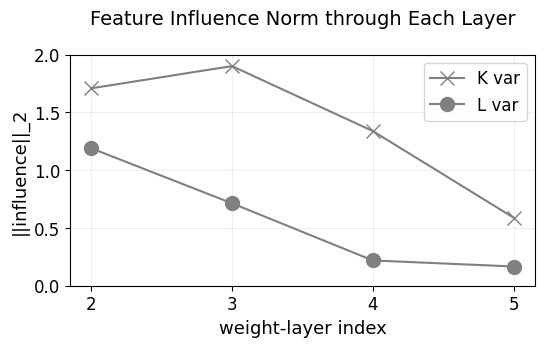

In [38]:
plot_feature_path(model_tf_1layer_y2, num_features=2, X_batch=X_K)

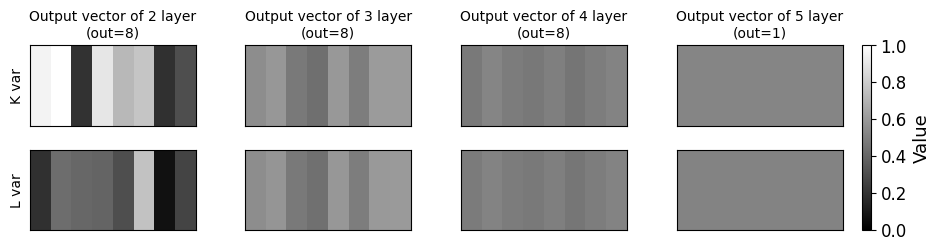

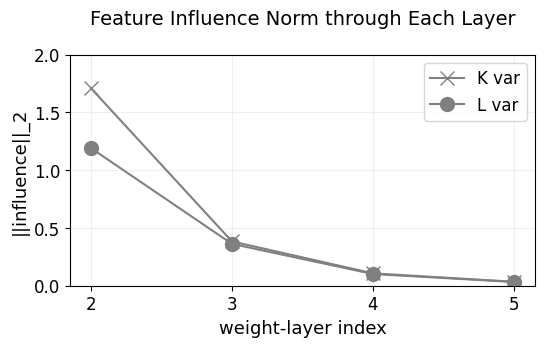

In [39]:
plot_feature_path(model_tf_1layer_y3, num_features=2, X_batch=X_L)